In [1]:
# import the necessary packages
from scipy.spatial import distance as dist
from collections import OrderedDict
import numpy as np

class CentroidTracker():
    def __init__(self, maxDisappeared=200):
        # initialize the next unique object ID along with two ordered
        # dictionaries used to keep track of mapping a given object
        # ID to its centroid and number of consecutive frames it has
        # been marked as "disappeared", respectively
        self.nextObjectID = 0
        self.objects = OrderedDict()
        self.disappeared = OrderedDict()

        # store the number of maximum consecutive frames a given
        # object is allowed to be marked as "disappeared" until we
        # need to deregister the object from tracking
        self.maxDisappeared = maxDisappeared
    
    def register(self, centroid):
        # when registering an object we use the next available object
        # ID to store the centroid
        self.objects[self.nextObjectID] = centroid
        self.disappeared[self.nextObjectID] = 0
        self.nextObjectID += 1
        
    def deregister(self, objectID):
        # to deregister an object ID we delete the object ID from
        # both of our respective dictionaries
        del self.objects[objectID]
        del self.disappeared[objectID]
        
    def update(self, rects, vects, min_dist):
        # check to see if the list of input bounding box rectangles
        # is empty
        if len(vects) == 0:
            # loop over any existing tracked objects and mark them
            # as disappeared
            for objectID in self.disappeared.keys():
                self.disappeared[objectID] += 1
 
                # if we have reached a maximum number of consecutive
                # frames where a given object has been marked as
                # missing, deregister it
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)
 
            # return early as there are no centroids or tracking info
            # to update
            return self.objects
        
        # initialize an array of input centroids for the current frame
        inputDetections = np.zeros((len(vects), len(vects[0])), dtype="int") #NEW 2:=len(vects[0])
 
        # loop over the bounding box rectangles
        #for (i, (startX, startY, endX, endY)) in enumerate(rects):
        #Changed coordinates
        for i  in range(len(vects)):
            # use the bounding box coordinates to derive the centroid
            #cX = int((startX + endX) / 2.0)
            #cY = int((startY + endY) / 2.0)
            inputDetections[i] = vects[i] #New (CX, cy):=vects[i]
            
        # if we are currently not tracking any objects take the input
        # detection and register each of them
        if len(self.objects) == 0:
            for i in range(0, len(inputDetections)):
                self.register(inputDetections[i])
                
        # otherwise, we are currently tracking objects so we need to
        # try to match the input centroids to existing object
        # centroids
        else:
            # grab the set of object IDs and corresponding centroids
            objectIDs = list(self.objects.keys())
            objectCentroids = list(self.objects.values())
 
            # compute the distance between each pair of object
            # centroids and input detection, respectively -- our
            # goal will be to match an input detection to an existing
            # object centroid
            D = dist.cdist(np.array(objectCentroids), inputDetections, 'euclidean')
            row_max = D.max(axis=1)
            maxim=max(row_max)
            D = D / maxim
            # in order to perform this matching we must (1) find the
            # smallest value in each row and then (2) sort the row
            # indexes based on their minimum values so that the row
            # with the smallest value is at the *front* of the index
            # list
            rows = D.min(axis=1).argsort()
 
            # next, we perform a similar process on the columns by
            # finding the smallest value in each column and then
            # sorting using the previously computed row index list
            cols = D.argmin(axis=1)[rows]
            
            s=[]
            #for (row, col) in zip(rows, cols):
            for z in range(len(rows)):
                if D[rows[z]][cols[z]]>min_dist:
                #print(row, col, D[row][col])
                    s.append(z)
            rows=np.delete(rows,s)
            cols=np.delete(cols, s)
            
            
            # in order to determine if we need to update, register,
            # or deregister an object we need to keep track of which
            # of the rows and column indexes we have already examined
            usedRows = set()
            usedCols = set()
 
            # loop over the combination of the (row, column) index
            # tuples
            for (row, col) in zip(rows, cols):
                # if we have already examined either the row or
                # column value before, ignore it
                # val
                if row in usedRows or col in usedCols:
                    continue
 
                # otherwise, grab the object ID for the current row,
                # set its new centroid, and reset the disappeared
                # counter
                objectID = objectIDs[row]
                self.objects[objectID] = inputDetections[col]
                self.disappeared[objectID] = 0
 
                # indicate that we have examined each of the row and
                # column indexes, respectively
                usedRows.add(row)
                usedCols.add(col)
                
            # compute both the row and column index we have NOT yet
            # examined
            unusedRows = set(range(0, D.shape[0])).difference(usedRows)
            unusedCols = set(range(0, D.shape[1])).difference(usedCols)
            
            # in the event that the number of object centroids is
            # equal or greater than the number of input detections
            # we need to check and see if some of these objects have
            # potentially disappeared
            #if D.shape[0] >= D.shape[1]:
                # loop over the unused row indexes
            for row in unusedRows:
                    # grab the object ID for the corresponding row
                    # index and increment the disappeared counter
                objectID = objectIDs[row]
                self.disappeared[objectID] += 1
 
                    # check to see if the number of consecutive
                    # frames the object has been marked "disappeared"
                    # for warrants deregistering the object
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)
                        
            # otherwise, if the number of input centroids is greater
            # than the number of existing object centroids we need to
            # register each new input detection as a trackable object
            #else:
            for col in unusedCols:
                self.register(inputDetections[col])
 
        # return the set of trackable objects
        return self.objects

In [2]:
# import the necessary packages
import numpy as np
from matplotlib import pyplot as plt
import argparse
import imutils
import time
import cv2
import os
from datetime import datetime
import seaborn as sns

# construct the argument parse and parse the arguments
confidence_cutoff = 0.5 
thrsh=0.5 
min_dist=0.2

'''ap.add_argument("-t", "--threshold", type=float, default=0.3,
    help="threshold when applyong non-maxima suppression")
args = vars(ap.parse_args())'''

# load the COCO class labels our YOLO model was trained on
labelsPath ='/home/zamarseny/darknet/data/coco.names'#labelsPath = os.path.sep.join([args["yolo"], "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")
 
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
    dtype="uint8")

frm_nmb=0
start_time=datetime.now()
# derive the paths to the YOLO weights and model configuration
weightsPath ='/home/zamarseny/darknet/yolov3.weights'#weightsPath = os.path.sep.join([args["yolo"], "yolov3.weights"])
configPath ='/home/zamarseny/darknet/cfg/yolov3.cfg'#configPath = os.path.sep.join([args["yolo"], "yolov3.cfg"])
 
# load our YOLO object detector trained on COCO dataset (80 classes)
# and determine only the *output* layer names that we need from YOLO
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

ct = CentroidTracker()

hog = cv2.HOGDescriptor()

# initialize the video stream, pointer to output video file, and
# frame dimensions
#vs=cv2.VideoCapture('/home/zamarseny/Data_Science/input_data/MOT_Challenge_Visualize.mp4')
#vs=cv2.VideoCapture('/home/zamarseny/Data_Science/input_data/3_cams/3_cams.mp4')
#vs=cv2.VideoCapture('/home/zamarseny/Data_Science/input_data/test_multicamera.avi')
vs=cv2.VideoCapture('/home/zamarseny/Data_Science/input_data/horizontal_panorama_LQ.avi')
#vs=cv2.VideoCapture('/home/zamarseny/Data_Science/input_data/Gavriil_input.MOV')
#vs=cv2.VideoCapture('/home/zamarseny/Data_Science/input_data/test_multicamera_MOT1.avi')
writer = None
(W, H) = (None, None)
 
# try to determine the total number of frames in the video file
try:
    prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
        else cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))
    print("[INFO] {} total frames in video".format(total))
 
# an error occurred while trying to determine the total
# number of frames in the video file
except:
    print("[INFO] could not determine # of frames in video")
    print("[INFO] no approx. completion time can be provided")
    total = -1

# loop over frames from the video file stream
while True:
    # read the next frame from the file
    (grabbed, frame) = vs.read()
    frame1=frame.copy()
    # if the frame was not grabbed, then we have reached the end
    # of the stream
    if not grabbed:
        break
 
    # if the frame dimensions are empty, grab them
    if W is None or H is None:
        (H, W) = frame1.shape[:2]

    # construct a blob from the input frame and then perform a forward
    # pass of the YOLO object detector, giving us our bounding boxes
    # and associated probabilities
    blob = cv2.dnn.blobFromImage(frame1, 1 / 255.0, (416, 416),
        swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    layerOutputs = net.forward(ln)
    end = time.time()
 
    # initialize our lists of detected bounding boxes, confidences,
    # and class IDs, respectively
    boxes = []
    confidences = []
    classIDs = []
    rects=[]
    vects=[]
    
    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability)
            # of the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
 
            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            if confidence > confidence_cutoff and classID==0:#if confidence > args["confidence"]:
                # scale the bounding box coordinates back relative to
                # the size of the image, keeping in mind that YOLO
                # actually returns the center (x, y)-coordinates of
                # the bounding box followed by the boxes' width and
                # height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
 
                # use the center (x, y)-coordinates to derive the top
                # and and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
 
                # update our list of bounding box coordinates,
                # confidences, and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)
                
    # apply non-maxima suppression to suppress weak, overlapping
    # bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidence_cutoff,#args["confidence"],
        thrsh)#args["threshold"])
 
    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
 
            # draw a bounding box rectangle and label on the frame
            color = (50, 250, 50)#[int(c) for c in COLORS[classIDs[i]]]
            cv2.rectangle(frame1, (x, y), (x + w, y + h), color, 2)
            #text = "{}: {:.2f}".format(LABELS[classIDs[i]],
            #    confidences[i])
            text = "{:.2f}".format(confidences[i])
            cv2.putText(frame1, text, (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            rects.append([x, y, (x+w), (y+h)])
            
            
            (means, stds) = cv2.meanStdDev(frame[abs(y):(y+h), abs(x):(x+w)])
            #(means, stds) = cv2.meanStdDev(frame[rects[i][1]:rects[i][3], rects[i][0]:rects[i][2]])
            #h1 = hog.compute(frame[abs(y):(y+h), abs(x):(x+w)])
            #hist_of_grad=cv2.calcHist(h1,[0],None,[8],[0, 256])
            #hist_colour=cv2.calcHist(frame[abs(y):(y+h), abs(x):(x+w)],[0, 1, 2],None,[4, 4, 4],[0, 256, 0, 256, 0, 256])
            #vects.append(hist_colour.flatten())
            #vects.append(np.concatenate([means, stds]).flatten())
            #vects.append([x, y, (x+w), (y+h)])
            vects.append(means.flatten())
            #vects.append(cv2.calcHist(frame[abs(y):(y+h), abs(x):(x+w)], [0, 1, 2], None, [3, 3, 3], [0, 256, 0, 256, 0, 256]).ravel())
            
    objects = ct.update(rects, vects, min_dist) #rects
    
    centroids=[]
    centroidIDS=[]
    
    for (objectID, centroid) in objects.items():
        centroids.append(centroid)
        centroidIDS.append(objectID)
    
    if len(objects)==1 and len(vects)>0: #Temporary block
        (x, y) = (boxes[0][0], boxes[0][1])
        (w, h) = (boxes[0][2], boxes[0][3])
        print(frm_nmb, centroidIDS[0], x, y, centroid)
        text = "ID {}".format(centroidIDS[0])
        cv2.putText(frame1, text, (int((2*x+w)/2) - 10, int((2*y+h)/2) - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        cv2.circle(frame1, (int((2*x+w)/2), \
                           int((2*y+h)/2)), 6, (0, 0, 255), -1)
    
    
    if len(objects)>1 and len(vects)>1: #NEW
        D1 = dist.cdist(centroids, vects, 'euclidean') #euclidian  cosine
        row_max_D1 = D1.max(axis=1)
        maxim_D1=max(row_max_D1)
        D1 = D1 / maxim_D1
        cols = D1.argmin(axis=1)
        rows = D1.argmin(axis=0)
            
            # loop over the tracked objects
    #counter=0
    #for (objectID, centroid) in objects.items():
        #for counter in cols:
        for counter in range(len(rows)):
        # draw both the ID of the object and the centroid of the
        # object on the output frame
        #(x, y) = (boxes[cols[counter]][0], boxes[cols[counter]][1])
        #(w, h) = (boxes[cols[counter]][2], boxes[cols[counter]][3])
            (x, y) = (rects[counter][0], rects[counter][1])
            (w, h) = (rects[counter][2]-rects[counter][0], rects[counter][3]-rects[counter][1])
            text = "ID {}".format(centroidIDS[rows[counter]])
            cv2.putText(frame1, text, (int((2*x+w)/2) - 10, int((2*y+h)/2) - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            cv2.circle(frame1, (int((2*x+w)/2), \
                           int((2*y+h)/2)), 6, (0, 0, 255), -1)
        #Temporary fix
            if counter==len(boxes)-1:
                break;
        #counter+=1

    cur_time=datetime.now()#.strftime('%Y-%m-%d %H:%M:%S')
    d=cur_time-start_time
    
    '''   ''' 
    cv2.putText(frame1, 'frm_nmb: '+str(frm_nmb)+\
                    ' FPS: ' +str("{0:0.1f}".format(frm_nmb/(d.seconds+0.1))) \
                    + 'objects_no'+ str(len(objects))+ 'detections_no' +str(len(vects)) \
                    #+"CPU %: " + str((psutil.cpu_percent())) \
                    #+", frame_N: "+str(frm_nmb)\
                    #+", memory %: " + str(dict(psutil.virtual_memory()._asdict())['percent'])
                    #, (50,425, cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,50,100), 2);
                    , (int(frame.shape[1]*0.1),int(frame.shape[0]*0.9)), \
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (200,50,50), 2);        
    
    #cv2.imshow("Frame", frame) #NEW
    #print(frm_nmb, 'detections_nmb', len(vects), 'objects_no', len(objects))
    cv2.imshow("Frame", frame1) #cv2.resize(frame1, (800,600))
    
    # check if the video writer is None
    if writer is None:
        # initialize our video writer
        #fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        fourcc = cv2.VideoWriter_fourcc(*"XVID")
        writer = cv2.VideoWriter('output.avi', fourcc, 15,
            (frame.shape[1], frame.shape[0]), True)
 
        # some information on processing single frame
        if total > 0:
            elap = (end - start)
            print("[INFO] single frame took {:.4f} seconds".format(elap))
            print("[INFO] estimated total time to finish: {:.4f}".format(
                elap * total))
 
    # write the output frame to disk
    writer.write(frame1)
    frm_nmb+=1
    key = cv2.waitKey(1) & 0xFF
 
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
 
# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()
cv2.destroyAllWindows()

[INFO] loading YOLO from disk...
[INFO] 451 total frames in video
[INFO] single frame took 0.4175 seconds
[INFO] estimated total time to finish: 188.2798
54 0 865 329 [77 77 83]


RuntimeError: OrderedDict mutated during iteration

In [11]:
print('frame: ',frm_nmb, ', cou: ', counter, len(boxes))
print(' len(cols)', len(cols))
print(cols)
print(' len(vects)', len(vects))
print(vects[0:10])
print(' len(objects)', len(objects))
objects

frame:  35 , cou:  0 0
 len(cols) 3
[0 0 0]
 len(vects) 0
[]
 len(objects) 3


OrderedDict([(0, array([72, 75, 78])),
             (1, array([74, 76, 79])),
             (2, array([70, 72, 75]))])

In [12]:
#centroid
#D
#for (objectID, centroid) in objects.items():
#    print(objectID, centroid)
print(dist.cosine(objects[0], objects[1]))
print(objects[0], objects[1])
#print(np.dot(objects[20], objects[20]))

2.2248282105397088e-05
[72 75 78] [74 76 79]


In [7]:
#rects
vects

[]

In [40]:
D1[0:10,0:10]
#means.flatten().shape

array([[4.68040597e-01, 7.10543611e-01, 8.01818621e-02, 1.27120279e-01,
        5.45937863e-01, 5.24399183e-02, 8.10917679e-02, 2.63809745e-02,
        6.24869169e-02, 1.95779125e-01],
       [8.89015243e-03, 1.21591360e-01, 1.10086371e-01, 6.08052388e-02,
        1.33737322e-01, 1.39706506e-01, 1.04919239e-01, 2.12561455e-01,
        1.34906615e-01, 3.50847284e-02],
       [2.75274196e-01, 2.68156236e-02, 4.72124034e-01, 4.29445387e-01,
        4.73900646e-02, 5.81898471e-01, 4.81105683e-01, 6.29351319e-01,
        6.27046742e-01, 3.01315308e-01],
       [9.21014247e-02, 2.48497133e-01, 1.46523318e-02, 7.93772075e-04,
        1.95775547e-01, 2.40995270e-02, 1.18758967e-02, 6.03390007e-02,
        2.53159701e-02, 8.60368792e-03],
       [1.29709020e-01, 1.68436534e-03, 2.83064296e-01, 2.40693288e-01,
        1.50067713e-02, 3.65395305e-01, 2.87613263e-01, 4.18572813e-01,
        3.94730131e-01, 1.48169707e-01],
       [2.75258329e-03, 1.23627288e-01, 1.37469673e-01, 8.03043721e-02,
   

23 0.0 341 374 104 156
(540, 960, 3) (33, 156, 3)
(array([[156.91783217],
       [158.43589744],
       [154.94347319]]), array([[42.39097777],
       [46.03050795],
       [48.12208588]]))


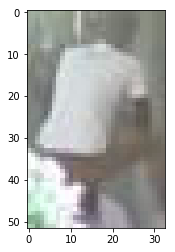

In [3]:
#print(len(classIDs))
(x, y) = (boxes[i][0], boxes[i][1])
(w, h) = (boxes[i][2], boxes[i][3])
print(i, float(confidence), x,(x+w), y,(y+h))
print(frame.shape, frame[x:(x+w), 0:(y+h)].shape)
#plt.imshow(frame[0:(y+h), x:(x+w)])
#plt.imshow(frame[0:38, 510:542])

print(cv2.meanStdDev(frame[y:(y+h), x:(x+w)]))
plt.imshow(frame[abs(y):(y+h), x:(x+w)])

In [6]:
hog = cv2.HOGDescriptor()
#h1 = hog.compute(frame)
img=frame[abs(y):(y+h), x:(x+w)]
h1 = hog.compute(img)
#hist_of_grad=cv2.calcHist(h1,None ,None,[8],[0, 256])

error: OpenCV(4.0.0) /io/opencv/modules/core/src/matrix.cpp:424: error: (-215:Assertion failed) 0 <= _rowRange.start && _rowRange.start <= _rowRange.end && _rowRange.end <= m.rows in function 'Mat'


In [154]:
len(vects)

20

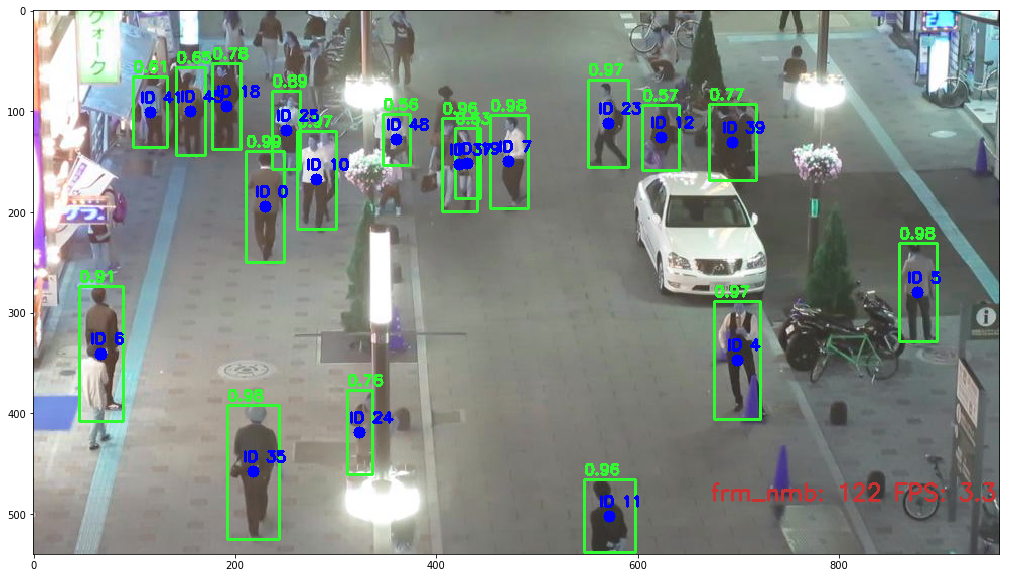

In [7]:
plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(frame1)

In [7]:
len(scores)

80

In [8]:
len(boxes)

27

In [8]:
rects

[[191, 194, 233, 312],
 [861, 228, 898, 330],
 [677, 286, 719, 404],
 [392, 72, 431, 161],
 [252, 71, 294, 168],
 [439, 65, 476, 155],
 [806, 125, 837, 197],
 [47, 273, 90, 395],
 [517, 76, 550, 190],
 [565, 487, 604, 539],
 [103, 183, 143, 289],
 [202, 37, 230, 122],
 [910, 117, 953, 200],
 [344, 141, 371, 201],
 [173, 60, 203, 132],
 [-1, 425, 33, 537],
 [593, 9, 644, 81],
 [904, 111, 930, 204],
 [342, 103, 375, 157],
 [698, 108, 736, 197],
 [144, 48, 179, 143],
 [268, 80, 297, 158],
 [711, 120, 737, 182],
 [102, 61, 131, 139],
 [313, 381, 338, 453],
 [739, 34, 769, 99]]

In [9]:
objects

OrderedDict([(0, array([125, 116, 109,  21,  26,  29])),
             (1, array([153, 158, 152,  49,  49,  51])),
             (2, array([134, 131, 139,  35,  39,  37])),
             (3, array([82, 76, 73, 13, 16, 21])),
             (4, array([ 99,  96, 100,  36,  38,  39])),
             (5, array([90, 93, 89, 22, 23, 23])),
             (6, array([135, 131, 128,  44,  55,  59])),
             (7, array([102, 103, 102,  18,  23,  24])),
             (8, array([113, 109, 101,  13,  16,  17])),
             (9, array([79, 79, 74, 22, 26, 26])),
             (10, array([129, 130, 136,  44,  48,  55])),
             (11, array([120, 118, 114,  37,  38,  40])),
             (12, array([116, 121, 119,  34,  36,  34])),
             (13, array([109, 112, 114,  18,  24,  26])),
             (14, array([96, 90, 91, 22, 30, 37])),
             (15, array([119, 126, 128,  16,  18,  20])),
             (16, array([91, 88, 86, 23, 26, 27])),
             (17, array([144, 142, 142,  37,  37,  34]

In [6]:
print(W, H)

960 540


In [10]:
cou=0
obj=[]
IDS=[]
for (objectID, centroid) in objects.items():
    obj.append(centroid)
    IDS.append(objectID)
    print(objectID, centroid)
    cou+1
    if cou>40:
        break;

0 [125 116 109  21  26  29]
1 [153 158 152  49  49  51]
2 [134 131 139  35  39  37]
3 [82 76 73 13 16 21]
4 [ 99  96 100  36  38  39]
5 [90 93 89 22 23 23]
6 [135 131 128  44  55  59]
7 [102 103 102  18  23  24]
8 [113 109 101  13  16  17]
9 [79 79 74 22 26 26]
10 [129 130 136  44  48  55]
11 [120 118 114  37  38  40]
12 [116 121 119  34  36  34]
13 [109 112 114  18  24  26]
14 [96 90 91 22 30 37]
15 [119 126 128  16  18  20]
16 [91 88 86 23 26 27]
17 [144 142 142  37  37  34]
18 [102  97  95  20  29  35]
19 [110 108 118  25  35  45]
20 [106 105 104  18  22  23]
21 [119 117 113  38  39  41]
22 [116 121 116  26  31  31]
23 [93 84 82 21 25 31]
24 [109 112 106  52  54  57]
25 [141 142 145  49  53  58]
26 [150 139 130  18  19  19]
27 [120 122 117  24  28  28]
28 [89 88 85 26 26 26]
29 [157 157 153  41  44  46]
30 [91 91 87 27 28 28]
31 [103 108 110  33  35  31]
32 [139 135 137  40  41  44]


In [11]:
obj[0:8]
#print(obj[22:32])

[array([125, 116, 109,  21,  26,  29]),
 array([153, 158, 152,  49,  49,  51]),
 array([134, 131, 139,  35,  39,  37]),
 array([82, 76, 73, 13, 16, 21]),
 array([ 99,  96, 100,  36,  38,  39]),
 array([90, 93, 89, 22, 23, 23]),
 array([135, 131, 128,  44,  55,  59]),
 array([102, 103, 102,  18,  23,  24])]

In [12]:
obj[22:32]

[array([116, 121, 116,  26,  31,  31]),
 array([93, 84, 82, 21, 25, 31]),
 array([109, 112, 106,  52,  54,  57]),
 array([141, 142, 145,  49,  53,  58]),
 array([150, 139, 130,  18,  19,  19]),
 array([120, 122, 117,  24,  28,  28]),
 array([89, 88, 85, 26, 26, 26]),
 array([157, 157, 153,  41,  44,  46]),
 array([91, 91, 87, 27, 28, 28]),
 array([103, 108, 110,  33,  35,  31])]

In [15]:
min_dist=0.04
objectIDs = IDS[0:8]#[0,1,2]

objectCentroids = obj[0:8]
'''[[2,2],\
                   [7,3],\
                   [6,8]]'''

inputDetections=obj[22:32]
'''[[3,2],\
                 [7,5],\
                 [7,7],\
                 [5,8],\
                 [2,6]]'''
# compute the distance between each pair of object
# centroids and input detection, respectively -- our
# goal will be to match an input detection to an existing
# object centroid
D = dist.cdist(np.array(objectCentroids), inputDetections, 'cosine')

row_max = D.max(axis=1)
maxim=max(row_max)
D = D / maxim

# in order to perform this matching we must (1) find the
# smallest value in each row and then (2) sort the row
# indexes based on their minimum values so that the row
# with the smallest value is at the *front* of the index
# list
rows = D.min(axis=1).argsort()
 
            # next, we perform a similar process on the columns by
            # finding the smallest value in each column and then
            # sorting using the previously computed row index list
cols = D.argmin(axis=1)[rows]  #NEW
            
            # in order to determine if we need to update, register,
            # or deregister an object we need to keep track of which
            # of the rows and column indexes we have already examined
usedRows = set()
usedCols = set()
 
            # loop over the combination of the (row, column) index
            # tuples
print(rows, cols)

s=[]
#for (row, col) in zip(rows, cols):
for i in range(len(rows)):
    if D[rows[i]][cols[i]]>min_dist:
        print(i, D[rows[i]][cols[i]])
        s.append(i)
print(s)
rows=np.delete(rows,s)
cols=np.delete(cols, s)
''''''
print(rows, cols)
            # if we have already examined either the row or
                # column value before, ignore it
                # val    
for (row, col) in zip(rows, cols):
                # if we have already examined either the row or
                # column value before, ignore it
                # val
    if row in usedRows or col in usedCols:
        continue
 
                # otherwise, grab the object ID for the current row,
                # set its new centroid, and reset the disappeared
                # counter
    objectID = objectIDs[row]
#self.objects[objectID] = inputDetections[col]
#self.disappeared[objectID] = 0
 
                # indicate that we have examined each of the row and
                # column indexes, respectively
    usedRows.add(row)
    usedCols.add(col)
                
            # compute both the row and column index we have NOT yet
            # examined
unusedRows = set(range(0, D.shape[0])).difference(usedRows)
unusedCols = set(range(0, D.shape[1])).difference(usedCols)
            
            # in the event that the number of object centroids is
            # equal or greater than the number of input detections
            # we need to check and see if some of these objects have
            # potentially disappeared


'''
if D.shape[0] >= D.shape[1]:
                # loop over the unused row indexes
    for row in unusedRows:
                    # grab the object ID for the corresponding row
                    # index and increment the disappeared counter
        objectID = objectIDs[row]
        self.disappeared[objectID] += 1
 
                    # check to see if the number of consecutive
                    # frames the object has been marked "disappeared"
                    # for warrants deregistering the object
        if self.disappeared[objectID] > self.maxDisappeared:
                        self.deregister(objectID)
                        
            # otherwise, if the number of input centroids is greater
            # than the number of existing object centroids we need to
            # register each new input detection as a trackable object
else:
    for col in unusedCols:
        self.register(inputDetections[col])
 
        # return the set of trackable objects
        return self.objects
'''

[5 7 1 4 2 6 0 3] [0 5 8 3 7 3 5 5]
7 0.04426182337426127
[7]
[5 7 1 4 2 6 0] [0 5 8 3 7 3 5]


'\nif D.shape[0] >= D.shape[1]:\n                # loop over the unused row indexes\n    for row in unusedRows:\n                    # grab the object ID for the corresponding row\n                    # index and increment the disappeared counter\n        objectID = objectIDs[row]\n        self.disappeared[objectID] += 1\n \n                    # check to see if the number of consecutive\n                    # frames the object has been marked "disappeared"\n                    # for warrants deregistering the object\n        if self.disappeared[objectID] > self.maxDisappeared:\n                        self.deregister(objectID)\n                        \n            # otherwise, if the number of input centroids is greater\n            # than the number of existing object centroids we need to\n            # register each new input detection as a trackable object\nelse:\n    for col in unusedCols:\n        self.register(inputDetections[col])\n \n        # return the set of trackable obje

In [33]:
np.set_printoptions(precision=3)
#print(D)
#for i in range(len(objectCentroids)):
    #for j in range(len(inputDetections)):
        #print('{:4}'.format(D[i][j]))
#print(D[1][1])
print('argmin', D.argmin(axis=0))
print('min in row, ',D.min(axis=1))#.argsort())#rows)
print('min in col, ',D.min(axis=0))#.argsort())

print(D.min(axis=1).argsort())
print('rows, ',rows)
print('cols, ',cols)
print('used, unused rows ', usedRows, unusedRows)
print('used, unused cols ', usedCols, unusedCols)
objectIDs

argmin [5 1 6 4 0 7 1 5 1 1]
min in row,  [0.039 0.007 0.021 0.044 0.007 0.004 0.032 0.006]
min in col,  [0.004 0.086 0.123 0.007 0.111 0.006 0.014 0.016 0.007 0.022]
[5 7 1 4 2 6 0 3]
rows,  [5 7 1 4 2 6 0]
cols,  [0 5 8 3 7 3 5]
used, unused rows  {1, 2, 4, 5, 7} {0, 3, 6}
used, unused cols  {0, 3, 5, 7, 8} {1, 2, 4, 6, 9}


[0, 1, 2, 3, 4, 5, 6, 7]

In [32]:
plt.rcParams["figure.figsize"] = (20,15)

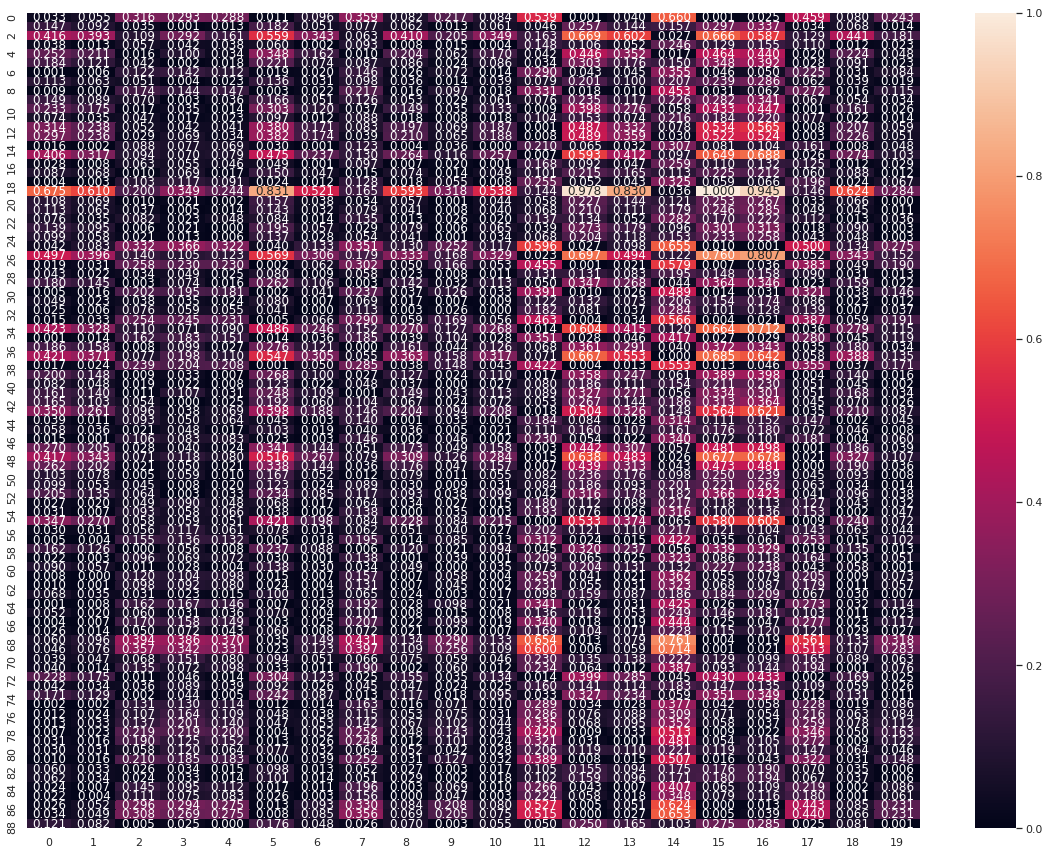

In [33]:
import seaborn as sns; sns.set()
ax = sns.heatmap(D1, annot=True, fmt="0.3f") #[0:10, 0:10]

In [54]:
print(len(cols))
cols

37


array([ 0,  2, 18,  9,  4,  1,  5, 14,  7, 13,  3,  6,  8, 20, 12,  2, 15,
       19, 16,  3, 14,  2, 13,  8, 10,  3,  7, 21, 21, 11, 16, 15, 10, 13,
        9, 11, 17])